In [96]:
from IPython.display import HTML
from matplotlib import animation, rc

import pandas as pd
import numpy as np
import os, json
import matplotlib.pyplot as plt
import math
%matplotlib inline

from opmap.cmap import bipolar
from opmap.videoData import VideoData
from opmap.vmemMap import VmemMap
from opmap.phaseMapHilbert import PhaseMapHilbert
from opmap.phaseVarianceMap import PhaseVarianceMap

from elecpy.util.loader import Loader

import scipy
import copy

In [104]:
def sess2vmem(sess):
    V = sess.data['vmem']
    cam = VideoData(*V.shape)
    vmem = VmemMap(cam)
    vmem.data = 2*(V - V.min())/(V.max() - V.min()) - 1.0
    del(cam)
    return vmem

In [20]:
def phaseComplement(value):
    value -= (value > np.pi)*2*np.pi
    value += (value < - np.pi)*2*np.pi
    return value

def topologic_charge(P):
    P_dx = np.zeros_like(P)
    P_dy = np.zeros_like(P)
    P_dx[:, :-1] = phaseComplement(P[:,1:] - P[:,:-1])
    P_dy[:-1,:] = phaseComplement(P[1:,:] - P[:-1,:])

    filter_dx = [[1,1],[0,0],[-1,-1]]
    filter_dy = [[-1,0,1], [-1,0,1]]

    integ_dx = scipy.signal.convolve2d(P_dx, filter_dx, mode='same', boundary='symm')
    integ_dy = scipy.signal.convolve2d(P_dy, filter_dy, mode='same', boundary='symm')
    return np.abs(integ_dx+integ_dy)/2*np.pi

def phase_variance(P):
    im_cos = np.cos(P)
    im_sin = np.sin(P)
    f = np.ones((3,3))
    f /= np.sum(f)
    im_cos = scipy.signal.convolve2d(im_cos, f, mode='same', boundary='symm')
    im_sin = scipy.signal.convolve2d(im_sin, f, mode='same', boundary='symm')
    im_pv = 1-np.abs(im_cos+1j*im_sin)
    return im_pv

In [4]:
with open('./sim_params_all.json', 'r') as f: params_all = json.load(f)

for i, sim_id in enumerate(sorted(params_all.keys())):
    print i, sim_id

0 20190730-1441_00
1 20190730-1441_01
2 20190730-1441_02
3 20190730-1441_03
4 20190730-1441_04
5 20190730-1441_05
6 20190730-1441_06
7 20190730-1441_07
8 20190730-1441_08
9 20190730-1441_09
10 20190730-1441_10
11 20190730-1441_11
12 20190730-1441_12
13 20190730-1441_13
14 20190730-1441_14
15 20190730-1441_15
16 20190730-1441_16
17 20190730-1441_17
18 20190730-1441_18
19 20190730-1441_19
20 20190730-1441_20
21 20190730-1441_21
22 20190730-1441_22
23 20190730-1441_23
24 20190730-1441_24
25 20190807-1440_00
26 20190807-1440_01
27 20190807-1440_02
28 20190807-1440_03
29 20190807-1440_04
30 20190807-1440_05
31 20190807-1440_06
32 20190807-1440_07
33 20190807-1440_08
34 20190807-1440_09
35 20190807-1440_10
36 20190807-1440_11
37 20190807-1440_12
38 20190807-1440_13
39 20190807-1440_14
40 20190807-1440_15
41 20190807-1440_16
42 20190807-1440_17
43 20190807-1440_18
44 20190807-1440_19
45 20190807-1440_20
46 20190807-1440_21
47 20190807-1440_22
48 20190807-1440_23
49 20190807-1440_24
50 2019092

In [115]:
list_sim = sorted(params_all.keys())[15:16]
list_sim

[u'20190730-1441_15']

In [116]:
for sim_id in list_sim[0:]:
    
    print(sim_id)
    params = params_all[sim_id]
    print(params)
    
    keys = ['vmem']

    sess = Loader(
        os.path.join(params['log']['path'], 'out.h5'), 
        keys=keys
    )

    print(sess.L)


20190730-1441_15
{u'cell_type': u'mahajan', u'log': {u'path': u'/mnt/Omer/Project/02.CumulativePhaseVariance/SimulationResults/20190730-1441_15', u'cnt': 200}, u'mask': {u'c_brugada': u'/mnt/Omer/Project/02.CumulativePhaseVariance/mask/homo_1.4.npy'}, u'stimulation': {}, u'fibroblast': {u'distribution': u'/mnt/Omer/Project/02.CumulativePhaseVariance/SimulationResults/20190730-1441_15/dist_fib.npy', u'type': u'fib'}, u'time': {u'end': 5000, u'udt': 0.005}, u'geometory': {u'width': 200, u'ds': 0.015, u'height': 200}, u'restart': {u'count': 0, u'source': u'/mnt/Omer/Project/02.CumulativePhaseVariance/SimulationResults/20171128-1/'}}
5001


## Topologic ChargeとPhase Varianceの比較

In [173]:
dst_dir = "/mnt/Shelter/Project/01.PhaseDiscontinuity/AnalysisResults/2019-12-08"
dst_dir = os.path.join(dst_dir, sim_id)
print(dst_dir)
if not os.path.exists(dst_dir): os.makedirs(dst_dir)

/mnt/Shelter/Project/01.PhaseDiscontinuity/AnalysisResults/2019-12-08/20190730-1441_15


In [118]:
sess.data["vmem"] = sess.data["vmem"][3000:4000,50:150,50:150]
sess.L = len(sess.data["vmem"])

In [120]:
vmem = sess2vmem(sess)

In [124]:
pmap = PhaseMapHilbert(vmem, width=100, sigma_xy=1, sigma_t =1)

In [144]:
P = pmap.data[580:780,25:,25:]
V = vmem.data[580:780,25:,25:]

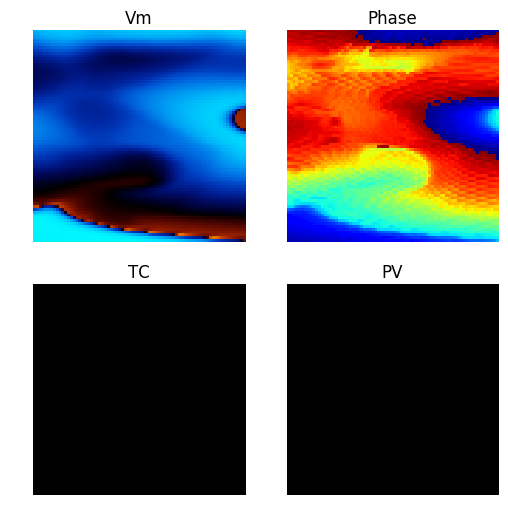

In [191]:
opt_vmem = {"cmap":bipolar(neutral=0, lutsize=1024), "vmin":-1, "vmax":1, "interpolation":"nearest"}
#opt_phase = {"cmap":"hsv", "vmin":-np.pi, "vmax":np.pi}
opt_phase = {"cmap":"jet", "vmin":-np.pi, "vmax":np.pi, "interpolation":"nearest"}
opt_gray = {"cmap":"gray", "vmin":0, "vmax":1, "interpolation":"nearest"}

fig = plt.figure(figsize=(6,6))

ax = plt.subplot(221)
plt.axes(ax)
plt.axis('off')
plt.title("Vm")
disp_v = plt.imshow(V[0], **opt_vmem)

ax = plt.subplot(222)
plt.axes(ax)
plt.axis('off')
plt.title("Phase")
disp_p = plt.imshow(P[0], **opt_phase)

ax = plt.subplot(223)
plt.axes(ax)
plt.axis('off')
plt.title("TC")
disp_tc = plt.imshow(np.zeros(P[0].shape), **opt_gray)

ax = plt.subplot(224)
plt.axes(ax)
plt.axis('off')
plt.title("PV")
disp_pv = plt.imshow(np.zeros(P[0].shape), **opt_gray)


In [192]:
def update(i):
    disp_v.set_array(V[i])
    disp_p.set_array(P[i])
    disp_tc.set_array(topologic_charge(P[i]))
    disp_pv.set_array(phase_variance(P[i]))
    fig.suptitle('{0} #{1:0>4}ms'.format(sim_id,i))
    
ani = animation.FuncAnimation(fig, update, interval=15, frames=len(P))
ani.save(os.path.join(dst_dir,'out.avi'), writer='ffmpeg')

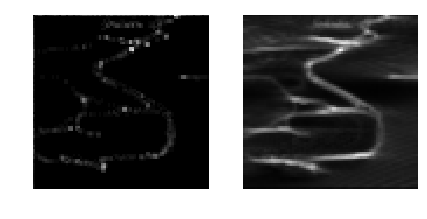

In [193]:
im_cpv = np.mean(np.array([phase_variance(im) for im in P]), axis=0)
im_ctc = np.mean(np.array([topologic_charge(im) for im in P]), axis=0)

plt.figure(figsize=(4,2))
plt.subplot(121)
plt.imshow(im_ctc, cmap='gray', interpolation='nearest', vmax=im_ctc.max(), vmin=0 )
#plt.title("TC")
plt.axis('off')
plt.subplot(122)
plt.imshow(im_cpv, cmap='gray', interpolation='nearest', vmax=im_cpv.max(), vmin=0)
#plt.title("PV")
plt.axis('off')

plt.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.95)
plt.savefig(os.path.join(dst_dir, "plot_cumulated.png"))

In [194]:
out_path = os.path.join(dst_dir, "plot")
print(out_path)
if not os.path.exists(out_path): os.makedirs(out_path)

/mnt/Shelter/Project/01.PhaseDiscontinuity/AnalysisResults/2019-12-08/20190730-1441_15/plot


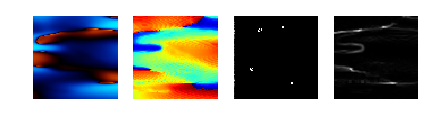

In [195]:
plt.figure(figsize=(4,1))
for i, (im_p, im_v) in enumerate(zip(P, V)):
    
    ax = plt.subplot(141)
    plt.axes(ax)
    plt.axis('off')
    #plt.title("Vm")
    plt.imshow(im_v, **opt_vmem)

    ax = plt.subplot(142)
    plt.axes(ax)
    plt.axis('off')
    #plt.title("Phase")
    plt.imshow(im_p, **opt_phase)

    ax = plt.subplot(143)
    plt.axes(ax)
    plt.axis('off')
    #plt.title("TC")
    plt.imshow(topologic_charge(im_p), **opt_gray)

    ax = plt.subplot(144)
    plt.axes(ax)
    plt.axis('off')
    #plt.title("PV")
    plt.imshow(phase_variance(im_p), **opt_gray)

    plt.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.95)
    plt.savefig(os.path.join(out_path, "{0:0>6}.png".format(i)))
    